# Intro
This notebook shows how we processed American Community Survey data, downloaded from IPUMS, into usable reference tables for our analysis.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from pprint import pprint
pd.set_option("max_columns",0)

Data pulled from [IPUMS](https://usa.ipums.org/usa/index.shtml). Data pull is filtered on 2 things: 
1) Person lives in the Northeast Region (Connecticut, Maine, Massachusetts, New Hampshire, Rhode Island, Vermont, New Jersey, New York, Pennsylvania)  
2) Person works in New York State  
![ipums screenshot](images/ipums_data_pull.png)

### Read in data, clean up columns

In [3]:
### Read in reference tables. Puma names, TranWork reference table
puma_df = pd.read_csv("ipums_data/pumanames_us_2019_clean.csv",index_col=0)
### Tranwork allows 1-many matches to the HBD TranWork column
tranwork_df = pd.read_csv("ipums_data/ipums_tranwork_reference_updated.csv",index_col=0)
### Occupation Match Table
occupation_df = pd.read_csv("ipums_data/ipums_occupation_reference1819.csv",index_col=0)
### Industry Match Table
industry_df = pd.read_csv("ipums_data/ipums_industry_reference1819.csv",index_col=0)
### Distances reference table
dist_df = pd.read_csv("puma_distance_centroid.csv")

In [4]:
### Read in IPUMS data, join to puma + tranwork reference tables
### First, read in IPUMS data for all NE residents that work in NYS
### We will filter this down on only those that work in NYC
ipums_df_WorksNYS = pd.read_csv("ipums_data/ipums_data_all_NE.csv") 
ipums_df_WorksNYS = ipums_df_WorksNYS.merge(right=puma_df,on=["STATEFIP","PUMA"])
ipums_df_WorksNYS = ipums_df_WorksNYS.merge(right=tranwork_df,on=["TRANWORK"])
orig_len = len(ipums_df_WorksNYS)
### Filter down to just people who work in Manhattan (the lowest relevant granularity ACS has for P.O.W.)
### Has to be done at both state and PWPuma level - PWPUMA is state dependent
works_in_ny = ipums_df_WorksNYS['PWSTATE2']==36
works_in_manhattan = ipums_df_WorksNYS["PWPUMA00"]==3800

ipums_df_WorksNYS = ipums_df_WorksNYS[works_in_ny&works_in_manhattan]


pd.DataFrame([['Rows in Raw Data','Rows after filtering'],[orig_len,len(ipums_df_WorksNYS)]]).T

,0,1
0,Rows in Raw Data,289250
1,Rows after filtering,67328


In [6]:
### Second, read in IPUMS data for NY residents - we are going to filter those that 
###  live in Manhattan and work elsewhere

manhattan_pumanames = puma_df[puma_df['PUMA_NAME'].str.contains("NYC-Manh")]["PUMA_NAME"].values

ipums_df_NY_Res = pd.read_csv("ipums_data/ipums_ny_only.csv")
ipums_df_NY_Res = ipums_df_NY_Res.merge(right=puma_df,on=["STATEFIP","PUMA"])
ipums_df_NY_Res = ipums_df_NY_Res.merge(right=tranwork_df,on=["TRANWORK"])

orig_len = len(ipums_df_NY_Res)
### We want NYS residents who live in Manhattan, work, and don't work in Manhattan
works_in_ny = ipums_df_NY_Res['PWSTATE2']==36
works_in_manhattan = ipums_df_NY_Res["PWPUMA00"]==3800
lives_in_manhattan = ipums_df_NY_Res["PUMA_NAME"].isin(manhattan_pumanames)
works_at_all = ipums_df_NY_Res['PWSTATE2']>0

ipums_df_NY_Res = ipums_df_NY_Res[(~works_in_manhattan)&(lives_in_manhattan)&(works_at_all)]

pd.DataFrame([['Rows in Raw Data','Rows after filtering'],[orig_len,len(ipums_df_NY_Res)]]).T

,0,1
0,Rows in Raw Data,592340
1,Rows after filtering,2351


In [7]:
### Some quick checks

In [8]:
ipums_df_WorksNYS.groupby(by=["YEAR"]).agg({"PERWT":'sum'}) 
### This looks good - about 2.6MM commute into Manhattan (pre-COVID)

,PERWT
YEAR,
2017,2621994.0
2018,2622616.0
2019,2671634.0


In [9]:
ipums_df_NY_Res.groupby(by=["YEAR"]).agg({"PERWT":'sum'}) 
### This looks good
### About 122K Manhattan residents commuted outside of the borough for work (see source below)
# https://www1.nyc.gov/assets/planning/download/pdf/planning-level/housing-economy/nyc-ins-and-out-of-commuting.pdf

,PERWT
YEAR,
2017,145789.0
2018,137391.0
2019,122621.0


In [10]:
### Concatenate dataframes together - add commute_dir column for ease of filtering
ipums_df_WorksNYS['commute_dir'] = 'in'
ipums_df_NY_Res['commute_dir'] = 'out'

ipums_df = pd.concat([ipums_df_WorksNYS,ipums_df_NY_Res])

### Added April 24 - REMOVING 2017, Industry+Occupation codes changed in 17/18, so they arent consistent. 
### Removing for now. Can always try to re-marry later if we need/want to
ipums_df=ipums_df[ipums_df['YEAR']>2017]
ipums_df.reset_index(inplace=True)
print(len(ipums_df),'rows in ipums_df overall')
ipums_df.groupby(by=["YEAR",'commute_dir']).agg({"PERWT":'sum'}) 

### Looks good

47048 rows in ipums_df overall


PERWT
YEAR commute_dir           
2018 in           2622616.0
     out           137391.0
2019 in           2671634.0
     out           122621.0

In [11]:
ipums_df = ipums_df.merge(right=occupation_df,left_on='OCC',right_on='2018_Occupation_Code_Census',how='left').drop("2018_Occupation_Code_SOC",axis=1)

ipums_df = ipums_df.merge(right=industry_df,left_on='IND',right_on='2018_Industry_Code_Census',how='left').drop("2018_Industry_Code_NAICS",axis=1)

# ipums_df.drop(["OCC","2018_Occupation_Code_Census","IND","2018_Industry_Code_Census"],axis=1,inplace=True)

# ipums_df



In [12]:
### Check new industry/occupation data join
print(len(ipums_df[ipums_df['OCC'].isna()]), len(ipums_df[ipums_df['Occupation_Description'].isna()]))
      #will fill with "missing_occupation"

print(len(ipums_df[ipums_df['IND'].isna()]), len(ipums_df[ipums_df['Industry_Description'].isna()]))
print(len(ipums_df[ipums_df['IND'].isna()]), len(ipums_df[ipums_df['Industry_Category'].isna()]))

ipums_df['Occupation_Description'].fillna("missing_occupation",inplace=True)
ipums_df['Industry_Description'].fillna("missing_industry_description",inplace=True)
ipums_df['Industry_Category'].fillna("missing_industry_category",inplace=True)

ipums_df.groupby(by=['YEAR','Occupation_Description']).agg({"PERWT":"sum"}).sort_values(by='PERWT',ascending=False)
ipums_df.groupby(by=['YEAR','Industry_Category']).agg({"PERWT":"sum"}).sort_values(by='PERWT',ascending=False)


1563 1563
1563 1563
1563 1563


PERWT
YEAR Industry_Category                                           
2018 Professional, Scientific, and Management, and A...  542513.0
2019 Professional, Scientific, and Management, and A...  539784.0
     Educational Services, and Health Care and Socia...  515421.0
2018 Educational Services, and Health Care and Socia...  493294.0
2019 Finance and Insurance, and Real Estate, and Ren...  422883.0
2018 Finance and Insurance, and Real Estate, and Ren...  402688.0
2019 Arts, Entertainment, and Recreation, and Accomm...  296521.0
2018 Arts, Entertainment, and Recreation, and Accomm...  284097.0
     Retail Trade                                        181985.0
2019 Retail Trade                                        181925.0
     Information                                         158317.0
2018 Information                                         154861.0
     missing_industry_category                           137391.0
     Construction                                        128356.0
2019 Construction                                        124983.0
     missing_industry_category                           122621.0
2018 Other Services, Except Public Administration        116430.0
2019 Other Services, Except Public Administration        109113.0
2018 Public Administration                               100776.0
2019 Public Administration                               100500.0
2018 Transportation and Warehousing, and Utilities        97611.0
2019 Transportation and Warehousing, and Utilities        95136.0
     Manufacturing                                        75500.0
2018 Manufacturing                                        69357.0
2019 Wholesale Trade                                      54688.0
2018 Wholesale Trade                                      53768.0
2019 Military                                              2154.0
2018 Agriculture, Forestry, Fishing, and Hunting, an...    1863.0
2019 Agriculture, Forestry, Fishing, and Hunting, an...    1784.0
2018 Military                                               409.0

In [13]:
### Clean up some columns and convert to legible values

## Sex
ipums_df["SEX"] = ipums_df["SEX"].replace({1:"M",2:"F"})

## Health Conditions
health_cols = ['DIFFREM','DIFFPHYS','DIFFMOB','DIFFCARE','DIFFSENS','DIFFEYE','DIFFHEAR']
ipums_df[health_cols]=ipums_df[health_cols].replace({1:0,2:1})

## Home Ownership / Rental
ipums_df["OWNERSHP_LABEL"]=ipums_df["OWNERSHP"].replace({0:"N/A",1:"Rent",2:"Own"})

## Race
ipums_df["RACE_LABEL"]=ipums_df["RACE"].replace({1:"White",2:"BlackAA",3:"AmerIndianAlaskan"\
                                                    ,4:"Chinese",5:"Japanese",6:"OtherAsianPacIsl"\
                                                    ,7:"OtherRace",8:"TwoRaces",9:"ThreePlusRaces"})
## Education Level
ipums_df["EDUC_LABEL"]=ipums_df["EDUC"].replace({0:"N/A_NoSchool",1:"Grade0_4",2:"Grades5_8"\
                                                    ,3:"Grade9",4:"Grade10",5:"Grade11"\
                                                    ,6:"Grades12",7:"College_1Year",8:"College_2Year"\
                                                    ,9:"College_3Year",10:"College_4Year"\
                                                 ,11:"College_5PlusYears"})

## Daily Work Hours
## UHRSWORK reports the number of hours per week that the respondent usually worked,
ipums_df['HRS_WK_DAILY'] = ipums_df['UHRSWORK']/5


### Create Hourly Columns from Departs/Arrives times
ipums_df["DEPARTS_HOUR"] = ipums_df["DEPARTS"]//100
ipums_df["ARRIVES_HOUR"] = ipums_df["ARRIVES"]//100

### Vehicles
ipums_df['VEHICLE_AVAILBLE'] = ipums_df['VEHICLES'].apply(lambda x: 0 if x==0 or x==9 else 1)

### Adding PUMA_KEY as per team's request
ipums_df['PUMAKEY_HOME'] = ipums_df['STATEFIP'].astype(str).str.zfill(2)+"_"+ipums_df['PUMA'].astype(str).str.zfill(5)

ipums_df['PUMAKEY_WORK'] = ipums_df['PWSTATE2'].astype(str).str.zfill(2)+"_"+ipums_df['PWPUMA00'].astype(str).str.zfill(5)

In [14]:
ipums_df['VEHICLES'].value_counts()
ipums_df['VEHICLE_AVAILBLE'].value_counts() #looks good - 0 and 9 together make 18,129

1    29026
0    18129
Name: VEHICLE_AVAILBLE, dtype: int64

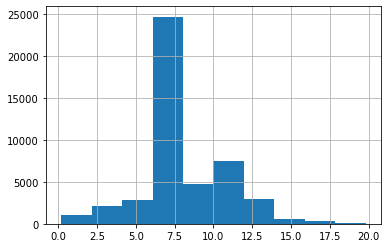

In [15]:
ipums_df['HRS_WK_DAILY'].hist(); #that looks about right

In [16]:
### Check out the data
print((ipums_df.shape))
ipums_df.head(5)

(47155, 72)


,index,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,REGION,STATEFIP,COUNTYFIP,DENSITY,CITY,PUMA,STRATA,GQ,OWNERSHP,OWNERSHPD,CINETHH,VEHICLES,PERNUM,PERWT,SEX,AGE,RACE,RACED,HISPAN,HISPAND,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC,IND,WKSWORK2,UHRSWORK,INCTOT,POVERTY,DIFFREM,DIFFPHYS,DIFFMOB,DIFFCARE,DIFFSENS,DIFFEYE,DIFFHEAR,PWSTATE2,PWCOUNTY,PWPUMA00,TRANWORK,CARPOOL,RIDERS,TRANTIME,DEPARTS,ARRIVES,PUMA_NAME,TRANWORK_DESC,TRANWORK_HBDMATCH,TRANWORK_CLEAN,commute_dir,2018_Occupation_Code_Census,Occupation_Description,Industry_Category,Industry_Description,2018_Industry_Code_Census,OWNERSHP_LABEL,RACE_LABEL,EDUC_LABEL,HRS_WK_DAILY,DEPARTS_HOUR,ARRIVES_HOUR,VEHICLE_AVAILBLE,PUMAKEY_HOME,PUMAKEY_WORK
0,49,2018,201801.0,250561.0,2.018000e+12,18.0,2.018003e+12,11.0,9,5,415.4,0.0,500,50009.0,1.0,1,12,1,6.0,1.0,19.0,F,48,1,100,0,0,11,114,1,10,1530.0,6672.0,6,50,718000,501,0,0,0,0,0,0,0,36,61,3800,10,1,1,90,532,704,Litchfield County,"Auto, truck, or van",AutoOccupants,AutoOccupants,in,1530.0,Other engineers,Information,Internet publishing and broadcasting and web s...,6672.0,Rent,White,College_5PlusYears,10.0,5,7,1,09_00500,36_03800
1,52,2018,201801.0,250774.0,2.018000e+12,61.0,2.018003e+12,11.0,9,5,415.4,0.0,500,50009.0,1.0,1,13,1,2.0,2.0,62.0,M,46,1,100,0,0,11,114,1,10,4820.0,6970.0,6,50,718000,501,0,0,0,0,0,0,0,36,61,3800,10,1,1,20,932,954,Litchfield County,"Auto, truck, or van",AutoOccupants,AutoOccupants,in,4820.0,"Securities, commodities, and financial service...","Finance and Insurance, and Real Estate, and Re...","Securities, commodities, funds, trusts, and ot...",6970.0,Rent,White,College_5PlusYears,10.0,9,9,1,09_00500,36_03800
2,55,2018,201801.0,253259.0,2.018001e+12,123.0,2.018003e+12,11.0,9,5,415.4,0.0,500,50009.0,1.0,1,13,1,2.0,1.0,123.0,M,47,6,620,0,0,11,115,1,10,3090.0,7970.0,6,45,400000,501,0,0,0,0,0,0,0,36,61,3800,10,1,1,90,532,704,Litchfield County,"Auto, truck, or van",AutoOccupants,AutoOccupants,in,3090.0,Physicians,"Educational Services, and Health Care and Soci...",Offices of physicians,7970.0,Rent,OtherAsianPacIsl,College_5PlusYears,9.0,5,7,1,09_00500,36_03800
3,56,2018,201801.0,253259.0,2.018001e+12,123.0,2.018003e+12,11.0,9,5,415.4,0.0,500,50009.0,1.0,1,13,1,2.0,2.0,57.0,F,45,1,100,0,0,11,115,1,10,3090.0,7870.0,6,40,300000,501,0,0,0,0,0,0,0,36,61,3800,10,1,1,90,532,704,Litchfield County,"Auto, truck, or van",AutoOccupants,AutoOccupants,in,3090.0,Physicians,"Educational Services, and Health Care and Soci...","Colleges, universities, and professional schoo...",7870.0,Rent,White,College_5PlusYears,8.0,5,7,1,09_00500,36_03800
4,59,2018,201801.0,254435.0,2.018001e+12,31.0,2.018003e+12,11.0,9,5,415.4,0.0,500,50009.0,1.0,1,13,1,1.0,2.0,33.0,M,66,1,100,0,0,11,115,1,10,3090.0,7970.0,5,40,80000,501,0,0,0,0,0,0,0,36,61,3800,10,1,1,90,702,834,Litchfield County,"Auto, truck, or van",AutoOccupants,AutoOccupants,in,3090.0,Physicians,"Educational Services, and Health Care and Soci...",Offices of physicians,7970.0,Rent,White,College_5PlusYears,8.0,7,8,1,09_00500,36_03800


In [17]:
### Add distances - changed April 25
distances_df = pd.read_csv("puma_distance_centroid.csv")
ipums_df=ipums_df.merge(right=distances_df,on=["PUMAKEY_HOME","PUMAKEY_WORK"]\
                         ,how='left')
len(ipums_df) #matches above - good

47155

In [18]:
print("records without distance match",len(ipums_df[ipums_df["DISTANCE_KM"].isna()]))
print("records with distance match",len(ipums_df[~ipums_df["DISTANCE_KM"].isna()]))

records without distance match 80
records with distance match 47075


### Choosing columns



In [19]:
health_cols = ['DIFFREM','DIFFPHYS','DIFFMOB','DIFFCARE','DIFFSENS','DIFFEYE','DIFFHEAR']
other_columns_use = ["YEAR","PERWT","STATEFIP","PUMA",'PUMA_NAME',"SEX","AGE",'HRS_WK_DAILY'\
                     ,'INCTOT','TRANWORK_DESC','TRANWORK_HBDMATCH','OWNERSHP_LABEL'\
                    ,'RACE_LABEL','EDUC_LABEL','DEPARTS_HOUR','ARRIVES_HOUR','commute_dir','VEHICLE_AVAILBLE'\
                     ,"Occupation_Description","Industry_Category","Industry_Description","PUMAKEY_HOME","PUMAKEY_WORK","DISTANCE_KM"]
columns_use = other_columns_use+health_cols

rename_dict = {
     "YEAR":"YEAR"
    ,"PERWT":"PERWT"
    ,"STATEFIP":"HOME_STATEFIP"
    ,"PUMA":"HOME_PUMA"
    ,'PUMA_NAME':"PUMA_NAME"
    ,"SEX":"SEX"
    ,"AGE":"AGE"
    ,'HRS_WK_DAILY':'HRS_WK_DAILY'
    ,'INCTOT':"TOTAL_PERSONAL_INCOME"
    ,'TRANWORK_DESC':"MODE_TRANSP_TO_WORK"
    ,'TRANWORK_HBDMATCH':"MODE_TRANSP_TO_WORK_HBDMATCH"
    ,'OWNERSHP_LABEL':"HOMEOWNER_LABEL"
    ,'RACE_LABEL':"RACE_LABEL"
    ,'EDUC_LABEL':"EDUC_LABEL"
    ,'DEPARTS_HOUR':"DEPARTS_FOR_WORK_HOUR"
    ,'ARRIVES_HOUR':"ARRIVES_AT_WORK_HOUR"
    ,'commute_dir' :"COMMUTE_DIRECTION_MANHATTAN"
    ,'DIFFREM':"COGNITIVE_DIFFICULTY"
    ,'DIFFPHYS':"AMBULATORY_DIFFICULTY"
    ,'DIFFMOB':"IND_LIVING_DIFFICULTY"
    ,'DIFFCARE':"SELFCARE_DIFFICULTY"
    ,'DIFFSENS':"VISION_OR_HEARING_DIFFICULTY"
    ,'DIFFEYE':"VISION_DIFFICULTY"
    ,'DIFFHEAR':"HEARING_DIFFICULTY"
    ,'VEHICLE_AVAILBLE':"VEHICLE_AVAILABLE"
    ,"Occupation_Description":"OCC_DESCRIPTION"
    ,"Industry_Category":"IND_CAT"
    ,"Industry_Description":"IND_DESCRIPTION"
    ,"PUMAKEY_WORK":"PUMAKEY_WORK"
    ,"PUMAKEY_HOME":"PUMAKEY_HOME"
}
ipums_save_df = ipums_df[columns_use].rename(rename_dict,axis=1)
ipums_save_df.head(5)

,YEAR,PERWT,HOME_STATEFIP,HOME_PUMA,PUMA_NAME,SEX,AGE,HRS_WK_DAILY,TOTAL_PERSONAL_INCOME,MODE_TRANSP_TO_WORK,MODE_TRANSP_TO_WORK_HBDMATCH,HOMEOWNER_LABEL,RACE_LABEL,EDUC_LABEL,DEPARTS_FOR_WORK_HOUR,ARRIVES_AT_WORK_HOUR,COMMUTE_DIRECTION_MANHATTAN,VEHICLE_AVAILABLE,OCC_DESCRIPTION,IND_CAT,IND_DESCRIPTION,PUMAKEY_HOME,PUMAKEY_WORK,DISTANCE_KM,COGNITIVE_DIFFICULTY,AMBULATORY_DIFFICULTY,IND_LIVING_DIFFICULTY,SELFCARE_DIFFICULTY,VISION_OR_HEARING_DIFFICULTY,VISION_DIFFICULTY,HEARING_DIFFICULTY
0,2018,19.0,9,500,Litchfield County,F,48,10.0,718000,"Auto, truck, or van",AutoOccupants,Rent,White,College_5PlusYears,5,7,in,1,Other engineers,Information,Internet publishing and broadcasting and web s...,09_00500,36_03800,170.50491,0,0,0,0,0,0,0
1,2018,62.0,9,500,Litchfield County,M,46,10.0,718000,"Auto, truck, or van",AutoOccupants,Rent,White,College_5PlusYears,9,9,in,1,"Securities, commodities, and financial service...","Finance and Insurance, and Real Estate, and Re...","Securities, commodities, funds, trusts, and ot...",09_00500,36_03800,170.50491,0,0,0,0,0,0,0
2,2018,123.0,9,500,Litchfield County,M,47,9.0,400000,"Auto, truck, or van",AutoOccupants,Rent,OtherAsianPacIsl,College_5PlusYears,5,7,in,1,Physicians,"Educational Services, and Health Care and Soci...",Offices of physicians,09_00500,36_03800,170.50491,0,0,0,0,0,0,0
3,2018,57.0,9,500,Litchfield County,F,45,8.0,300000,"Auto, truck, or van",AutoOccupants,Rent,White,College_5PlusYears,5,7,in,1,Physicians,"Educational Services, and Health Care and Soci...","Colleges, universities, and professional schoo...",09_00500,36_03800,170.50491,0,0,0,0,0,0,0
4,2018,33.0,9,500,Litchfield County,M,66,8.0,80000,"Auto, truck, or van",AutoOccupants,Rent,White,College_5PlusYears,7,8,in,1,Physicians,"Educational Services, and Health Care and Soci...",Offices of physicians,09_00500,36_03800,170.50491,0,0,0,0,0,0,0


In [20]:
ipums_save_df.groupby(by=["YEAR",'COMMUTE_DIRECTION_MANHATTAN']).agg({"PERWT":'sum'})  #looks good

PERWT
YEAR COMMUTE_DIRECTION_MANHATTAN           
2018 in                           2628008.0
     out                           137391.0
2019 in                           2678709.0
     out                           122621.0

In [21]:
ipums_save_df.to_csv(f"disaggregated_cleaned_ipums_data.csv")